# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Надо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.
В нашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

### План работы

#### Шаг 1. Загрузка данных
Загрузим файл с данными и изучим их.

#### Шаг 2. Исследовательский анализ данных
Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

#### Шаг 3. Обучение модели на GPU
Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. Важно добиться значения MAE на тестовой выборке не больше 8.

#### Шаг 4. Анализ результатов по обучению модели

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from PIL import Image
import matplotlib.pyplot as plt

В нашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age. file_name - не информативен, а вот real_age как раз будет target-ом  в нашем датасете. Постороим далее по нему распределение.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Выводы:

- В датафрейме 7591 строка и два столбца
- Пропусков не наблюдаем
- file_name - не информативен, а вот real_age как раз будет target-ом  в нашем датасете

## Исследовательский анализ данных

Построим график распределения и боксплот по столбцу real_age: 

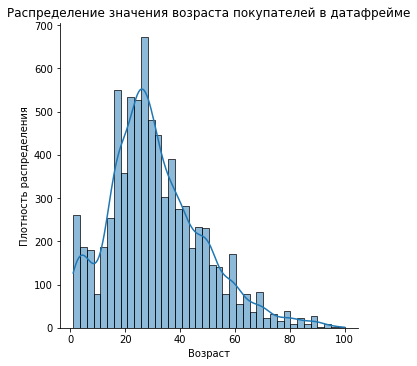

In [9]:
sns.displot(df['real_age'], bins=40, kde=True)
plt.title('Распределение значения возраста покупателей в датафрейме') 
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')

plt.show()

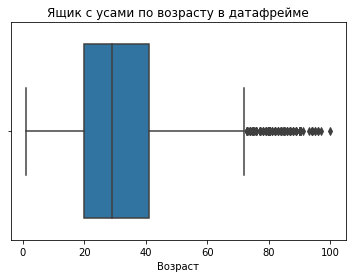

In [12]:
sns.boxplot(x=df['real_age'],orient='h')

plt.title('Ящик с усами по возрасту в датафрейме') 
plt.xlabel('Возраст')

plt.show()

- Данные распределены относительно нормально от 1 до 100 лет с всплеском ближе к нулю. При этом распределение смещено влево с пиком на значениях в 25-30 лет. К этому возрасту относится более 1100 объектов, поэтому нужно будет выравнить распределение числа фото людей с разными возрастами для одинаковой вероятности предсказания.

- Есть отдельные всплески в значениях возрастов, кратных 5. Возможно, это показатель округления значений возраста при подготовке датафрейма.

In [6]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Среднее немного выше медианы, стандартное отклонение довольно высокое.

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [15]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

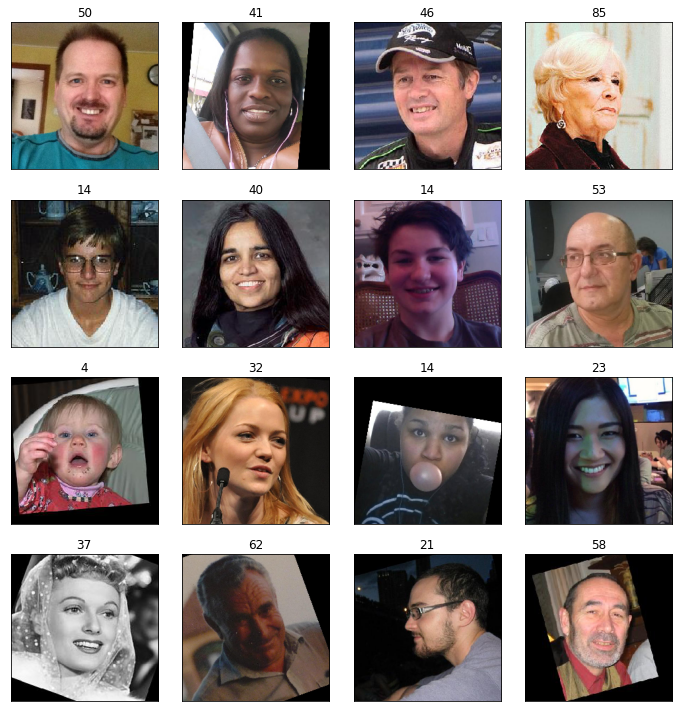

In [16]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошо, что возраст был указан в названии!
</div>

Данные загружены, в аутпут вывели фото с первого батча, 32 шт. Под каждым фото есть возраст человека.

Видим, что фото предобработаны: большинство из них содержат крупное изображение человеческого лица в анфас. Есть и артефакты: черный фон у некоторых изображений, часть фото - люди в профиль.

## Обучение модели

Обучим модель в GPU-тренажёре и сохраним результат вывода модели на экран. Наша задача побить baseline по MAE, оно должно быть меньше 8. Вспомним, что нужно подготовить данные: выровнять распределение фото по возрастам.

In [ ]:
def load_train(path):

    datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 30,
        height_shift_range = 30,
        zoom_range = [.8, .8],
        horizontal_flip = True, 
        rescale=1./255,
        validation_split=.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        #labels='inferred', 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        #batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow

def load_test(path):

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.25)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv') ,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        #sbatch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=.00001)
    model.compile(optimizer=optimizer_adam, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

    model.summary() 

    return model


def train_model(model,train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, epochs=15, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Мы взяли предобученную Resnet, не стали брать слои с верхушки, а взяли с Github. Замораживать верхушку ``backbone.trainable = False`` не стали, т.к. данных в датасете достаточно для обучения.

Еще горизонтально повернули изображения в целях агументации и увеличении датафрейма на обучающей выборке. Тестовая выборка находится на стороне тренажера, у нас к ней нет доступа.

При построении сети мы использовали оптимизатор Adam, который использует градиентный спуск при подборе весов нейронов и ускорят процесс обучения модели. Значения гиперпараметра мы взяли``lr=0.0003``

По совету из задания loss при обучении взяли ``MSE``, а саму метрику - ``MAE``. В итоге удалось побить контрольное значение по MAE. 

## Анализ обученной модели

В результате мы посмотрели на распределение таргетного признака, обучили модель в GPU-тренажёре и сохранили результат вывода модели на экран. По контрольной метрике MAE вышло на тестовой выборке меньше контрольного значения. 

В рамках обучения модели использовали аугментацию, чтобы улучшить качество предсказаний модели. Применили также архитектуру ResNet50, полносвязный слой с одним выходным нейроном и функцией ReLU. Задачу считаем выполненной.